# Time Series Anomaly Detection

<u>Scenario</u>: Discover anomalies in number of web pages accessed in a day by a user. Is there a bot copying the curriculum?

We will accomplish this by breaking down to the following tasks:

1. Acquire the data
1. Prepare the data
1. Make the analysis process work over all users.
    1. Compute necessary metrics to arrive at the final metric, %b (percent-b).
    1. Add user id to the dataframe that contains all the metrics, including %b.
    1. Filter to rows where %b indicates anomaly (i.e. > 1)
    1. Append rows of anomalies of new user to previous users' anomalous activity.
1. Turn the analysis process and calculations into a function that can be used to loop through for each user.
1. Test the function on a single user.
1. Analyze by looping over all users.


Finally, we will do a quick sample of exploration of the anomalies. There is much more you can do!

In [10]:
# numbers
import pandas as pd
import numpy as np

# vizzes
import matplotlib.pyplot as plt
import seaborn as sns

# access
import env

## Acquire

After doing some research, some experimentation of performing actions and watching the logs, we discovered what each of the fields represent. We then parse and name the fields accordingly.

In [2]:
# establishing link to mysql
url = f'mysql+pymysql://{env.user}:{env.password}@{env.host}/curriculum_logs'

query = '''
SELECT date,
       path as endpoint,
       user_id,
       cohort_id,
       ip as source_ip
FROM logs;
'''

In [4]:
# old way to ping sql
df = pd.read_sql(query, url)

In [5]:
# looking at the data
df.head()

,date,endpoint,user_id,cohort_id,source_ip
0,2018-01-26,/,1,8.0,97.105.19.61
1,2018-01-26,java-ii,1,8.0,97.105.19.61
2,2018-01-26,java-ii/object-oriented-programming,1,8.0,97.105.19.61
3,2018-01-26,slides/object_oriented_programming,1,8.0,97.105.19.61
4,2018-01-26,javascript-i/conditionals,2,22.0,97.105.19.61


In [6]:
# look at the data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 900223 entries, 0 to 900222
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   date       900223 non-null  object 
 1   endpoint   900222 non-null  object 
 2   user_id    900223 non-null  int64  
 3   cohort_id  847330 non-null  float64
 4   source_ip  900223 non-null  object 
dtypes: float64(1), int64(1), object(3)
memory usage: 34.3+ MB


## Prepare

just like we would for time series analysis! 

In [18]:
# set date as datetime type
df.date = df.date.astype('datetime64')

In [23]:
# set index as date
df = df.set_index('date')

In [24]:
# sort the index
df = df.sort_index()

In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 900223 entries, 2018-01-26 to 2021-04-21
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   endpoint   900222 non-null  object 
 1   user_id    900223 non-null  int64  
 2   cohort_id  847330 non-null  float64
 3   source_ip  900223 non-null  object 
dtypes: float64(1), int64(1), object(2)
memory usage: 34.3+ MB


No need to split because we are not modeling, we are using statistics to identify low probability cases.

### Exponential Moving Average
Simple Moving Average (SMA) time series are much less noisy than the time series of the original data points. The challenge with SMA, however, is that the values of SMA lag the original values. This means that changes in the trend are only seen with a delay (lag) of L time units. For datasets that contain rapid trend shifts, a SMA may simply be too slow to be useful. 

Exponential Moving Average (EMA) helps reduce the lag induced by the use of the SMA. It does this by putting more weight on more recent observations, while the SMA weights all observations equally.

EMA function:

 $EMA_t = \alpha *  (t_0 - EMA_{t-1}) + EMA_{t-1
}$

Where:

- t<sub>0</sub> = Latest value
- t<sub>−1</sub> = Previous value
- EMA<sub>*t−1*</sub> = Exponential moving average of previous day
- M = Number of time periods, span of the window
- $\alpha$ = multiplier = $2 \over M+1$

Instead of calculating EMA manually, we will use the pandas `ewm()` (Exponential Weighted functions) to compute our EMA. So we just need to define the following:

M = `span` argument = number of time periods. We will try 7 days, 14 days, 30 days, and 90 days.

In [26]:
# looking at endpoint (curriculm pages), get count for everyday 
pages = df['endpoint'].resample('D').count()
pages.head()

date
2018-01-26    572
2018-01-27    230
2018-01-28    170
2018-01-29    830
2018-01-30    652
Freq: D, Name: endpoint, dtype: int64

In [30]:
# tell me the ema for a period of 7 days, returns object, must agg function
ema_7d = pages.ewm(span=7).mean()
ema_7d

date
2018-01-26     572.000000
2018-01-27     376.571429
2018-01-28     287.243243
2018-01-29     485.737143
2018-01-30     540.235595
                 ...     
2021-04-17    1303.458794
2021-04-18    1142.344096
2021-04-19    1395.758072
2021-04-20    1529.318554
2021-04-21    1429.738915
Freq: D, Name: endpoint, Length: 1182, dtype: float64

Notice how there are no missing values. `ewm()` will use as many values as are available to compute the mean. 

So if the span is 7 days, but there is only one day of data available (i.e. the first day), the EMA will equal the first value.

In [32]:
# tell me the ema for a period of 14 days, returns object, must agg function
ema_14d = pages.ewm(span=14).mean()
ema_14d

date
2018-01-26     572.000000
2018-01-27     388.785714
2018-01-28     305.208829
2018-01-29     465.757252
2018-01-30     514.347700
                 ...     
2021-04-17    1348.173718
2021-04-18    1256.283889
2021-04-19    1376.246037
2021-04-20    1450.079899
2021-04-21    1407.535912
Freq: D, Name: endpoint, Length: 1182, dtype: float64

In [33]:
# tell me the ema for a period of 30 days, returns object, must agg function
ema_30d = pages.ewm(span=30).mean()
ema_30d

date
2018-01-26     572.000000
2018-01-27     395.300000
2018-01-28     315.139578
2018-01-29     457.002386
2018-01-30     501.369064
                 ...     
2021-04-17    1325.179115
2021-04-18    1282.199817
2021-04-19    1338.574023
2021-04-20    1376.730537
2021-04-21    1360.876954
Freq: D, Name: endpoint, Length: 1182, dtype: float64

In [34]:
# tell me the ema for a period of 90 days, returns object, must agg function
ema_90d = pages.ewm(span=90).mean()
ema_90d

date
2018-01-26     572.000000
2018-01-27     399.100000
2018-01-28     321.030081
2018-01-29     452.545042
2018-01-30     494.228442
                 ...     
2021-04-17    1192.041636
2021-04-18    1180.326435
2021-04-19    1201.769810
2021-04-20    1217.774869
2021-04-21    1215.867729
Freq: D, Name: endpoint, Length: 1182, dtype: float64

> Remember! These are *exponential* moving averages, not simple!

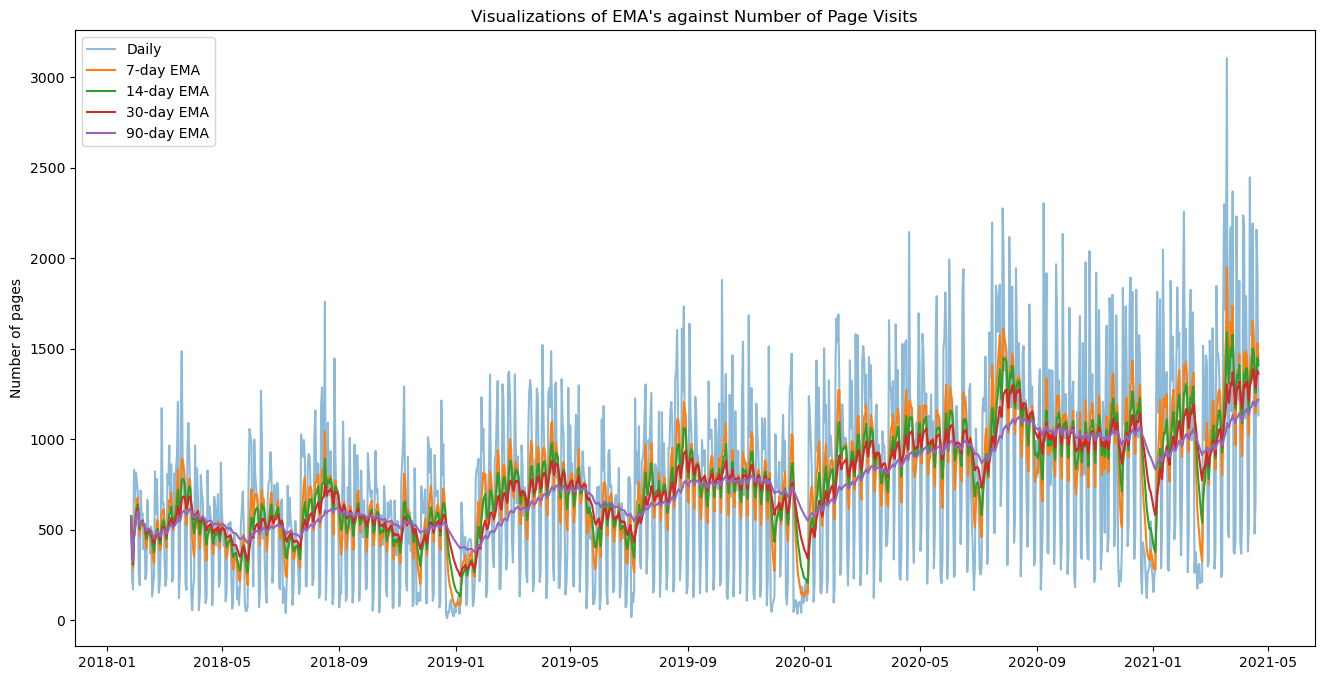

In [43]:
# visualize

# figsize set
fig, ax = plt.subplots(figsize=(16,8))

# daily pings
ax.plot(pages.index, pages, label='Daily', alpha=.5)

# different periods pings
ax.plot(pages.index, ema_7d, label = '7-day EMA')
ax.plot(pages.index, ema_14d, label = '14-day EMA')
ax.plot(pages.index, ema_30d, label = '30-day EMA')
ax.plot(pages.index, ema_90d, label = '90-day EMA')

ax.legend(loc='best')
ax.set_ylabel('Number of pages')
plt.title("Visualizations of EMA's against Number of Page Visits")

plt.show()

Let's look at a smaller date range to see how these EMAs react to changes in value:

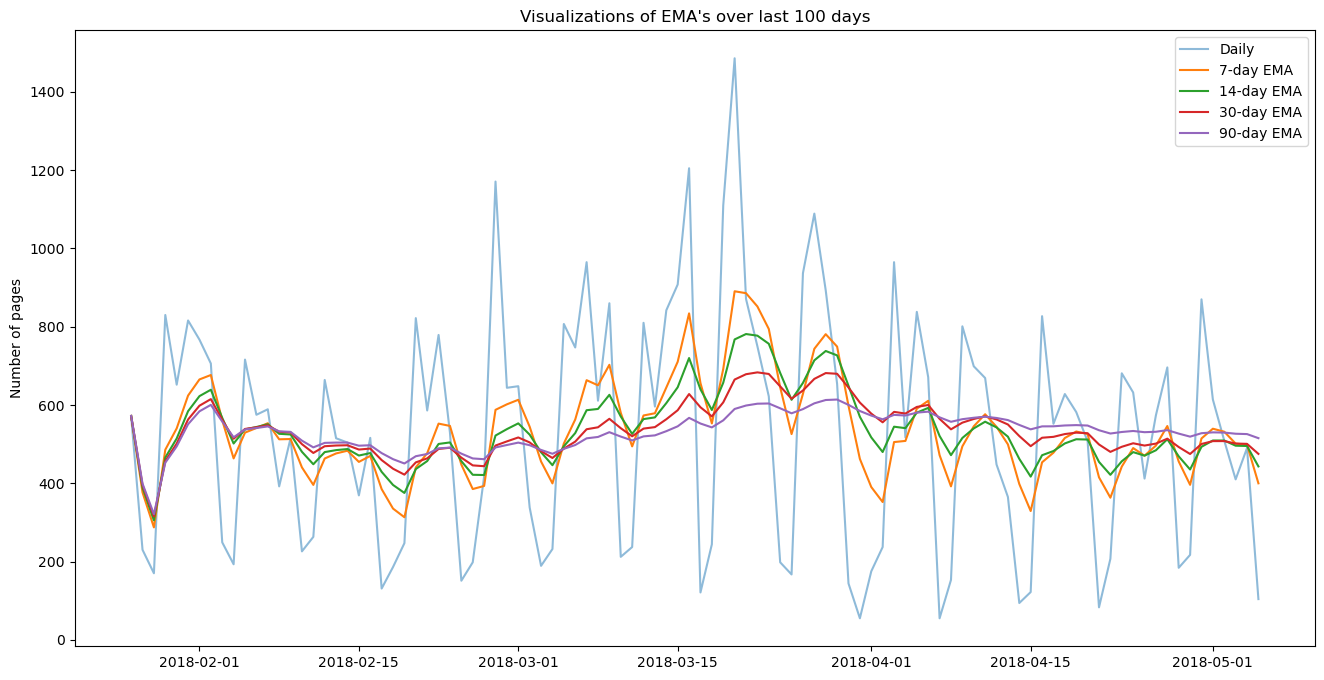

In [46]:
# visualize the last 100 days - zoom in

# figsize set
fig, ax = plt.subplots(figsize=(16,8))

# different period pings
ax.plot(pages.index[:100], pages[:100], label='Daily', alpha=.5)
ax.plot(pages.index[:100], ema_7d[:100], label = '7-day EMA')
ax.plot(pages.index[:100], ema_14d[:100], label = '14-day EMA')
ax.plot(pages.index[:100], ema_30d[:100], label = '30-day EMA')
ax.plot(pages.index[:100], ema_90d[:100], label = '90-day EMA')

ax.legend(loc='best')
ax.set_ylabel('Number of pages')
plt.title("Visualizations of EMA's over last 100 days")

plt.show()

## Bollinger Bands

- A volatility indicator commonly used in stock market, forex, and cryptocurrency trading.
- Made up of 3 lines, the Upper Band (UB), the Lower Band (LB) and the Midband.
- Based on the exponential moving average

### Midband

The Exponential Moving Average

`midband = train.ewm(span=30).mean()`

### Upper & Lower Band

UB/LB = Midband +/- stdev * K

K = the number of standard deviations to go up and down from the EMA

`stdev = train.ewm(span=30).std()`

### Bandwidth

The width of the bands

Bandwidth = (UB-LB) / midband * 100

### %b, Percent Bandwidth

Shows where the last value sits in relation to the bands.

%b = last−LB / UB-LB

- If %b > 1, data point lies above the upper band
- If %b < 0, data point lies below the lower band
- If %b == .5, data point lies on the midband.

In [ ]:
span = 30
k = 3

In [ ]:
# combine all 


### Plot the bands

In [ ]:
# fig, ax = plt.subplots(figsize=(12,8))

# ax.plot(my_df.index, my_df.pages, label='Number of Pages')

# ax.plot(my_df.index, my_df.midband, label = '30-day EMA/midband')
# ax.plot(my_df.index, my_df.ub, label = 'Upper Band')
# ax.plot(my_df.index, my_df.lb, label = 'Lower Band')

# ax.legend(loc='best')
# ax.set_ylabel('Number of pages')

# plt.show()

### Compute %b

Each data point will have a %b value that represents its relative position within/around the bollinger bands. It answers the question: Where does this point sit relative to a simple range of expected values? 

We can add a new column that shows the %b for every record in the dataset (except the first because there are no bollinger bands available for that one record)

%b = last−LB / UB-LB

Now, where do we see anomalies? We will search for %b values > 1. In this specific example, we don't need to search for values < 0 because a low extreme is not something we are concerned about. 

No anomalies found. Remember, the cutoff is based on the arbitrary selection for K earlier. We could always pick a different K.

Anyways great! There are no anomalies! Problem solved. 

...not so fast.

During our preparation step we resampled the data to a daily period. The bollinger bands and %b are only looking for individual days where the overall aggregate log activity was extreme. If the number of users is large enough, then an individual who is scraping our data may not be extreme enough to push a single day that far from the EMA. 

We need to dig deeper. Lets look at our data on a user by user basis:

In [ ]:
def acquire_logs(user=env.user, password=env.password, host=env.host):
    url = f'mysql+pymysql://{env.user}:{env.password}@{env.host}/curriculum_logs'
    query = '''
    SELECT date,
           path as endpoint,
           user_id,
           cohort_id,
           ip as source_ip
    FROM logs;
    '''
    df = pd.read_sql(query, url)
    return df

In [ ]:
def one_user_df_prep(df, user):
    df = df[df.user_id == user].copy()
    df.date = pd.to_datetime(df.date)
    df = df.set_index(df.date)
    df = df.sort_index()
    pages_one_user = df['endpoint'].resample('d').count()
    return pages_one_user

In [ ]:
def compute_pct_b(pages_one_user, span, k, user):
    midband = pages_one_user.ewm(span=span).mean()
    stdev = pages_one_user.ewm(span=span).std()
    ub = midband + stdev*k
    lb = midband - stdev*k
    
    my_df = pd.concat([pages_one_user, midband, ub, lb], axis=1)
    my_df.columns = ['pages_one_user', 'midband', 'ub', 'lb']
    
    my_df['pct_b'] = (my_df['pages_one_user'] - my_df['lb'])/(my_df['ub'] - my_df['lb'])
    my_df['user_id'] = user
    return my_df

In [ ]:
def plot_bands(my_df, user):
    fig, ax = plt.subplots(figsize=(12,8))
    ax.plot(my_df.index, my_df.pages_one_user, label='Number of Pages, User: '+str(user))
    ax.plot(my_df.index, my_df.midband, label = 'EMA/midband')
    ax.plot(my_df.index, my_df.ub, label = 'Upper Band')
    ax.plot(my_df.index, my_df.lb, label = 'Lower Band')
    ax.legend(loc='best')
    ax.set_ylabel('Number of Pages')
    plt.show()

In [ ]:
def find_anomalies(df, user, span, weight, plot=False):
    pages_one_user = one_user_df_prep(df, user)
    
    my_df = compute_pct_b(pages_one_user, span, weight, user)
    
    if plot:
        plot_bands(my_df, user)
    
    return my_df[my_df.pct_b>1]

# Using our functions:

#### Test function on a single user:

In [ ]:
user=1
span=30
k=6

No daily anomalies for user 1

#### Use function in a loop examining all users:

In [ ]:
k = 3.5

#### Are there users that show up more frequently than others?

#### Let's plot user #88:

#### Lets sort by the page counts:

#### Wow! User_id #341 looked at 272 pages in a single day. Lets plot their activity: